# Second order inchworm configuration and its contribution to the pseudo-particle self-energy

In [5]:
import Keldysh; kd = Keldysh
import KeldyshED; ked = KeldyshED; op = KeldyshED.Operators;

import QInchworm.ppgf

import QInchworm; cfg = QInchworm.configuration

import QInchworm.configuration: Expansion, InteractionPair
import QInchworm.configuration: Configuration, Node, InchNode, NodePair, NodePairs

import QInchworm.qmc_integrate: qmc_time_ordered_integral

┌ Info: Precompiling QInchworm [c1b6c5a0-2f71-4f50-a75d-692762eff855]
└ @ Base loading.jl:1278
┌ Warning: Package QInchworm does not have Test in its dependencies:
│ - If you have QInchworm checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with QInchworm
└ Loading Test into QInchworm from project dependency, future warnings for QInchworm are suppressed.


## Single correlated atom coupled to a bath level

System parameters

In [6]:
U = +1.0; # Coulomb interaction
μ = +0.5; # Chemical potential
ϵ = +0.1; # Bath energy level
V = -0.1; # Hybridization
β = 5.0;  # Inverse temperature

Discretization

In [7]:
nt = 10;
ntau = 50;
tmax = 1.0;

Exact Diagonalization

In [8]:
H = - μ * (op.n(0, "up") + op.n(0, "dn")) + U * op.n(0, "up") * op.n(0, "dn");
soi = ked.Hilbert.SetOfIndices([[0, "up"], [0, "dn"]]);
ed = ked.EDCore(H, soi);
ρ = ked.density_matrix(ed, β);

3-branch time contour

In [9]:
contour = kd.twist(kd.FullContour(tmax=tmax, β=β));
grid = kd.FullTimeGrid(contour, nt, ntau);

Hybridization function

In [10]:
Δ = kd.FullTimeGF(
    (t1, t2) -> -1.0im * V^2 *
        (kd.heaviside(t1.bpoint, t2.bpoint) - kd.fermi(ϵ, contour.β)) *
        exp(-1.0im * (t1.bpoint.val - t2.bpoint.val) * ϵ),
    grid, 1, kd.fermionic, true);

Pseudo Particle Strong Coupling Expansion

In [11]:
ip_up = InteractionPair(op.c_dag(0, "up"), op.c(0, "up"), Δ)
ip_dn = InteractionPair(op.c_dag(0, "dn"), op.c(0, "dn"), Δ)
ppsc_exp = Expansion(ed, grid, [ip_up, ip_dn]);

2nd order inchworm diagram on the imaginary branch

In [12]:
tau_grid = grid[kd.imaginary_branch]
τ_0, τ_β = tau_grid[1], tau_grid[end]

τ_i = τ_0
τ_f = τ_β
τ_w = tau_grid[end-1]

n_i = Node(τ_i.bpoint)
n_w = InchNode(τ_w.bpoint)
n_f = Node(τ_f.bpoint)

nodes = [n_f, n_w, n_i]
conf_0 = Configuration(nodes, NodePairs());
init = zero(cfg.eval(ppsc_exp, conf_0));

Quasi Monte Carlo integration over a $d = 3$ domain

In [13]:
function do_2nd_order_inchworm_diagram(τ_qmc, N)
    val = qmc_time_ordered_integral(3,
                                    contour,
                                    τ_i.bpoint,
                                    τ_f.bpoint,
                                    init = init,
                                    τ = τ_qmc,
                                    N = N) do τ
        # Loop over spin indices of hybridization lines
        sum = deepcopy(init)
        for index1 = 1:2, index2 = 1:2
            # 4 arrangements of creation and annihilation operators
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
        end
        sum
    end

    for (s, P_s) in enumerate(ppsc_exp.P)
        sf, mat = val[s]
        ppgf.set_matsubara(P_s, τ_f, mat)
    end
end

do_2nd_order_inchworm_diagram (generic function with 1 method)

## Numerical experiments

In [14]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

In [32]:
τ_qmc = 5
N_range = collect(10000:10000:1000000)
results = zeros(Complex{Float64}, length(N_range), 4)

Threads.@threads for (i, N) in collect(enumerate(N_range))
    do_2nd_order_inchworm_diagram(τ_qmc, N)
   
    res = [ppsc_exp.P[s][τ_f, τ_i][1] for s=1:4]
    println("τ_qmc = $τ_qmc, N = $N, res = ", res)
    results[i, :] = res
end

using HDF5
h5open("2nd_order_inchworm.h5", "cw") do file
    write(file, "tau_qmc", τ_qmc)
    write(file, "N_range", N_range)
    write(file, "results", results)
end

τ_qmc = 5, N = 10000, res = Complex{Float64}[-0.00015510953857726193 + 0.0im, -0.00015510953857726193 + 0.0im, 0.0 + 0.0im, -0.00015673922805614168 + 0.0im]
τ_qmc = 5, N = 20000, res = Complex{Float64}[-0.00015246822392905288 + 0.0im, -0.00015246822392905288 + 0.0im, 0.0 + 0.0im, -0.00015336959022750976 + 0.0im]
τ_qmc = 5, N = 30000, res = Complex{Float64}[-0.00015259453205736695 + 0.0im, -0.00015259453205736695 + 0.0im, 0.0 + 0.0im, -0.00015339094707262523 + 0.0im]
τ_qmc = 5, N = 40000, res = Complex{Float64}[-0.00015308488315030427 + 0.0im, -0.00015308488315030427 + 0.0im, 0.0 + 0.0im, -0.00015448304103554117 + 0.0im]
τ_qmc = 5, N = 110000, res = Complex{Float64}[-0.00015240233565443783 + 0.0im, -0.00015240233565443783 + 0.0im, 0.0 + 0.0im, -0.00015270863981459666 + 0.0im]
τ_qmc = 5, N = 50000, res = Complex{Float64}[-0.00015262776090065272 + 0.0im, -0.00015262776090065272 + 0.0im, 0.0 + 0.0im, -0.00015306646662121206 + 0.0im]
τ_qmc = 5, N = 60000, res = Complex{Float64}[-0.000152379

## TODO

- Obtain values for a fixed set of time points from pyppsc.
- Compare the full integrals with pyppsc.

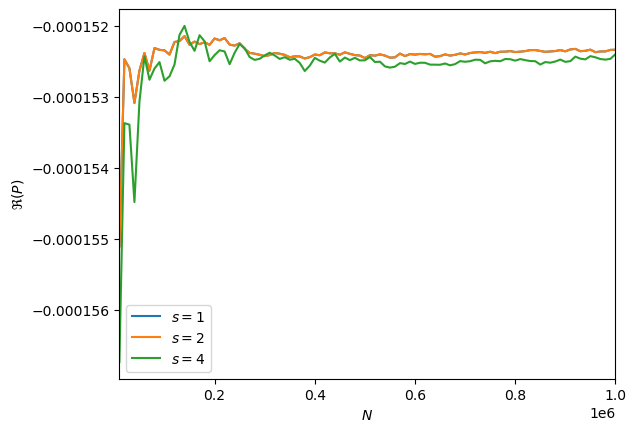

PyObject <matplotlib.legend.Legend object at 0x7f972673d9a0>

In [38]:
for s in [1,2,4]
    plt.plot(N_range, real(results[:, s]), label = "\$s=$s\$")
end
plt.xlabel(raw"$N$")
plt.ylabel(raw"$\Re(P)$")
plt.xlim(N_range[1], N_range[end])
plt.legend()